In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pickle
from multiprocessing import Pool
import random
import itertools
import time
import math
import scipy
from multiprocessing import Process

In [56]:
class Quantizer():
    def __init__(self, iters, dimC):
        self.iters = iters;
        self.C = None;
        self.EA = None;
        self.Eb = None;
        self.dimC = dimC;
        
    def load(self, grads):
        self.grads = grads;
        self.d = np.shape(grads)[0];
        self.m = np.shape(grads)[1];
        self.betas = np.ones((self.m,));
        self.points = []
        for i in range(self.dimC):
            xn = np.random.normal(0, 1, self.d);
            xn = xn * 1/np.linalg.norm(xn);
            self.points.append(xn);

    def objective(self, C, A):
        #print(np.shape(C), np.shape(A), np.shape(self.grads))
        total = 0;
        for i in range(self.m):
            total += self.betas[i]*np.square(np.linalg.norm(self.grads[:,i] - C@A))/np.square(np.linalg.norm(self.grads[i]))
        return total/self.m
    
    def compute(self, verbose):
        # Compute minimum covering ellipsoid #
        A = cp.Variable((self.d, self.d), PSD=True);
        b = cp.Variable(self.d);
        objective = cp.Minimize(-cp.log_det(A));
        constraints = [A == A.T];
        for i in range(self.m):
            constraints.append(cp.norm(A@self.grads[:,i] + b) <= 1);
        prob = cp.Problem(objective, constraints);
        print("Starting to compute Lowner-John Ellipsoid...")
        opt = prob.solve('SCS', eps=1e-2, max_iters = 50);
        A = A.value if A.value is not None else self.EA;
        b = b.value if b.value is not None else self.Eb;
        w, v = np.linalg.eigh(A);
        print("First solve status = ", prob.status)
        
        self.EA = A;
        self.Eb = b
        prob = None;
        indexes = range(self.dimC)
        pairs = list(itertools.combinations(indexes, 2))
        eijs = [np.zeros((self.dimC)) for i in range(len(pairs))];
        for index, pair in enumerate(pairs):
            eijs[index][pair[0]] = 1;
            eijs[index][pair[1]] = -1;
        
        # compute set C using N discrete points with SDP relaxation#
        R = np.linalg.norm(np.sum(self.grads, 1))
        X = cp.Variable((self.d, self.dimC));
        Y = cp.Variable((self.dimC, self.dimC));
        alpha = cp.Variable(1);
        B = cp.vstack([cp.hstack([np.identity(self.d), X]), cp.hstack([X.T, Y])])
        upper_bound = w[0];
        lower_bound = w[1]/self.dimC;
        constraints = [B >= 0, cp.diff(X, k=1, axis=1) <= R];
        expr = alpha + cp.sum(cp.diff(X, k=1, axis=1));
        for i in range(self.dimC):
            if(i < self.grads.shape[1]):
                expr += cp.norm(X[:,i] - self.grads[:, -i]);
            else:
                expr += cp.norm(X[:,i] - np.linalg.inv(A)@(random.choice(self.points) - b))
            constraints.append(cp.norm(A@X[:,i] + b) <= 1)
        for i in range(len(eijs)):
            constraints.append(- alpha <= eijs[i].T@Y@eijs[i]);
            constraints.append(alpha >= eijs[i].T@Y@eijs[i]);
        objective = cp.Minimize(expr);
        prob = cp.Problem(objective, constraints);
        flag = False;
        try:
            opt = prob.solve('ECOS', eps=1e-2)
        except:
            flag = True
        ## Catch infeasible case ##
        if(prob.status not in ['optimal', 'optimal_inaccurate'] or flag):
            print("Defaulted to border fitting");
            X = cp.Variable((self.d, self.dimC));
            alpha = cp.Variable(1);
            expr = 0; constraints = [];
            for i in range(self.dimC):
                if(i < self.grads.shape[1]):
                    expr += cp.norm(X[:,i] - self.grads[:, -i]);
                else:
                    expr += cp.norm(X[:,i] - np.linalg.inv(A)@(random.choice(self.points) - b))
                constraints.append(cp.norm(A@X[:,i] + b) <= 1 + alpha)
            objective = cp.Minimize(expr);
            prob = cp.Problem(objective, constraints);
            opt = prob.solve('ECOS');
            
        print("Second solve status = ", prob.status)
        self.C = self.C if X.value is None else X.value
        
        return opt
    
    def plot(self, grads):
        A = self.EA;
        b = self.Eb
        r = 1;
        #The lower this value the higher quality the circle is with more points generated
        stepSize = 0.01
        #Generated vertices
        positions = []
        t = 0
        while t < 2 * math.pi:
            positions.append(np.array([r * math.cos(t), r * math.sin(t)]))
            t += stepSize
        ellipsoid_coords_x = []
        ellipsoid_coords_y = []
        for pos in positions:
            point = np.linalg.inv(A)@(pos - b)
            ellipsoid_coords_x.append(point[0]);
            ellipsoid_coords_y.append(point[1]);
        plt.figure(1);
        plt.plot(grads[0,:], grads[1,:], 'b.', label='True grads');
        plt.plot(self.C[0,:], self.C[1,:], 'g.', label='Discrete (bin) points');
        plt.plot(ellipsoid_coords_x, ellipsoid_coords_y, 'r-', label='Parameterized ellipse');
        plt.legend(loc='upper right')
    
    def quantize(self, g):
        val = 0;
        index = 0;
        min_dist = float('inf');
        for i in range(self.dimC):
            dist = np.linalg.norm(self.C[:, i] - g)
            if(dist < min_dist):
                min_dist = dist;
                index = i;
        val = min_dist;
        print("Minimum relative distance = ", min_dist/np.linalg.norm(g));
        return (index, val)


In [118]:
## Distributed Least Squares Toy Model ##
class AgentLSQ():
    def __init__(self, A, b, nagents, r, dimC, qflag):
        self.A = A
        self.b = b
        self.r = r;
        self.nagents = nagents;
        self.grads = [];
        self.PASS = True;
        iters = 10000;
        self.Q = Quantizer(iters, dimC);
        self.qflag = qflag;
    
    def grad(self, x, flag):
        lmbda = 0.1
        g = self.A.T@self.A@x - self.A.T@self.b + lmbda*2*x
        self.grads.append(np.expand_dims(g, 1));
        ch = -1;
        qh = -1;
        bits = 0;
        if(self.qflag != 0): ## do not run if quantize
            flag = False;
        if(((len(self.grads)-self.r >= 0) or (len(self.grads) >= 2 and self.PASS)) and flag):
            G = np.hstack(self.grads);
            self.Q.load(G);
            start = time.time();
            ch = self.Q.compute(False);
            bits += self.Q.d * self.Q.dimC;
            print("Time to compute C = ", time.time() - start);
            self.grads = [];
            self.PASS = False;
            print("Recomputing C... | Converged with alpha value = ", ch)
        if(self.Q.C is not None and flag):
            bits += self.Q.dimC * (1/16);
            ghat, qh = self.Q.quantize(g) #self.Q.C.shape[1]
            return (self.Q.C[:,ghat], ch, qh, bits)
        else:
            if(self.qflag == 2):
                g = np.sign(g);
            print("Sending full precision gradients")
            bits += len(g)
            return (g, ch, qh, bits)

        
    def objective(self, x):
        return np.square(np.linalg.norm(self.A@x-self.b)) + np.square(np.linalg.norm(x));
    
class DLSQ():
    def __init__(self, m, n, nagents, lr, r, dimC, qflag):
        A = np.random.random((m,n))
        z = np.random.random((n,))
        b = A@z + np.random.random((m))

        print('Computing optimal...');
        self.optimal = np.square(np.linalg.norm(A@np.linalg.inv(A.T@A + 0.1*np.identity(n))@A.T@b-b))
        print('finished! | optimal = ', self.optimal)
        
        self.x = np.zeros((n,));
        self.m = m;
        self.n = n;
        self.r = r;
        self.nagents = nagents;
        self.lr = lr;  
        self.agents = self.distribute(A, b, nagents, r, dimC, qflag);
        
        self.A = A;
        self.b = b;
    
    def split(self, a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

    def distribute(self, A, b, nagents, r, dimC, qflag):
        agents = [];
        splits = list(self.split(range(self.m), self.nagents))
        
        for sp in splits:
            agents.append(AgentLSQ(A[sp, :], b[sp], self.nagents, r, dimC, qflag));
        return agents;
    
    def computeGradFromLocal(self, x, flag):
        temp = np.zeros((self.n,))
        normalizing = 0;
        total_bits = 0;
        for n in range(self.nagents):
            localgrad, ch, qh, bits = self.agents[n].grad(self.x, flag)
            total_bits += bits;
            temp += localgrad
            normalizing += np.linalg.norm(localgrad)
        
        return (temp/normalizing, ch, qh, total_bits);
    
    def step(self, i, flag):
        g, ch, qh, bits = self.computeGradFromLocal(self.x, flag);
        ak = (self.objective()-self.optimal)/np.square(np.linalg.norm(g));
        xnext = self.x - min(ak, self.lr/np.sqrt(i+1))*g
        self.x = xnext + 0.1*(xnext - self.x);
        return (ch, qh, bits);
    
    def objective(self):
        return np.sum([self.agents[i].objective(self.x) for i in range(self.nagents)])
        
    def run(self, iters, verbose):
        history = [];
        compute_history = [];
        quantize_history = [];
        bit_history = [];
        i = 0;
        run = True;
        while(run and i < iters):
            print("Current objective value = ", np.square(np.linalg.norm(self.A@self.x - self.b)) + np.square(np.linalg.norm(self.x)))
            gap = (self.objective()-self.optimal)/self.optimal
            print("Iteration = " + str(i) + " | Relative Optimality gap = " + str(gap))
            print("")
            if(np.abs(gap) <= 1e-1):
                run = False;
            history.append(gap);
            
            flag = True
            if(i >= self.r):
                flag = (np.diff(history[-3::], 1, 0) >= 0).all()
                flag = not flag
                
            ch, qh, bits = self.step(i, flag);
            bit_history.append(bits);
            if(ch != -1):
                compute_history.append(ch)
            if(qh != -1):
                quantize_history.append(qh);
            i += 1;
        #if(verbose):
        #    plt.yscale('log')
        #    plt.plot(range(i), history);
        return (history, compute_history, quantize_history, bit_history);

In [119]:
## Execute DLSQ without Quantization ##
def execute(nagents, dimC, r, m=10, n=10, iters=1000, lr=0.1, verbose=False, qflag=0): 
    dlsqexe = DLSQ(m, n, nagents, lr, r, dimC, qflag);
    history, compute_history, quantize_history, bit_history = dlsqexe.run(iters, True)
    comp_ratio = np.sum(bit_history)/(n*nagents*len(history));
    print("Compression ratio achieved = ", comp_ratio);
    print("Optimal = ", dlsqexe.optimal)
    print("")
    print("Done...")
    print("___________________________________________________________________")
    if(verbose):
        plt.figure(1);
        plt.yscale('log');
        plt.plot(range(len(history)), history);
        plt.figure(2);
        plt.yscale('log');
        plt.plot(range(len(compute_history)), compute_history);
        plt.figure(3);
        plt.yscale('log');
        plt.plot(range(len(quantize_history)), quantize_history);
        plt.figure(4);
        plt.yscale('log');
        plt.plot(range(len(bit_history)), bit_history);
    return history, compute_history, quantize_history, bit_history, comp_ratio
    
    

In [120]:
#test = execute(nagents=5, dimC=20, r=50, m=10000, n=50, iters=1000, lr=1.0, verbose=True, qflag=0)

In [121]:
# No quantization here #
h1, c1, q1, b1, cr1 = execute(nagents=5, dimC=5, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False, qflag=1)
h2, c2, q2, b2, cr2 = execute(nagents=5, dimC=5, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False, qflag=2)

Computing optimal...
finished! | optimal =  855.4520848722763
Current objective value =  1516484.0460292127
Iteration = 0 | Relative Optimality gap = 1771.7282133582414

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1422182.962498869
Iteration = 1 | Relative Optimality gap = 1661.492892404839

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1357334.033276828
Iteration = 2 | Relative Optimality gap = 1585.6863829205504

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1305510.5897899605
Iteration = 3 | Relative Optimality gap = 1525.1063307149138

Sending full p

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  502858.2548610729
Iteration = 55 | Relative Optimality gap = 586.837711230915

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  495532.2280040887
Iteration = 56 | Relative Optimality gap = 578.2739911822093

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  488324.2361025425
Iteration = 57 | Relative Optimality gap = 569.8482509502287

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective va

Iteration = 108 | Relative Optimality gap = 267.6657503105889

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  226280.7649739198
Iteration = 109 | Relative Optimality gap = 263.5374424555147

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  222792.76058012
Iteration = 110 | Relative Optimality gap = 259.4602716149173

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  219347.9088549838
Iteration = 111 | Relative Optimality gap = 255.43354513026233

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precisi

Current objective value =  126650.2718060819
Iteration = 144 | Relative Optimality gap = 147.07953687278692

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  124395.3687919695
Iteration = 145 | Relative Optimality gap = 144.44382971817487

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  122169.02390937656
Iteration = 146 | Relative Optimality gap = 141.84150628213015

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  119970.94518145655
Iteration = 147 | Relative Optimality gap = 139.27222525124944

Sending full precision gradients
Sending full precision gradients
S

Sending full precision gradients
Sending full precision gradients
Current objective value =  34771.05394097397
Iteration = 203 | Relative Optimality gap = 39.68786200623973

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  33822.290893298356
Iteration = 204 | Relative Optimality gap = 38.5789987314595

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  32890.6592424382
Iteration = 205 | Relative Optimality gap = 37.49016161588112

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  31976.03375884595
Iteration = 206 | Relative Optimality gap = 36.42120426931487

Sending 

Sending full precision gradients
Sending full precision gradients
Current objective value =  4861.061240668375
Iteration = 260 | Relative Optimality gap = 4.736161826251705

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4723.053297488377
Iteration = 261 | Relative Optimality gap = 4.575048178884188

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4596.59828765762
Iteration = 262 | Relative Optimality gap = 4.427439189582094

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4481.57224932342
Iteration = 263 | Relative Optimality gap = 4.293189825152157

Sending f

Current objective value =  2991.657186759715
Iteration = 323 | Relative Optimality gap = 2.5542380783546923

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2975.9561271208754
Iteration = 324 | Relative Optimality gap = 2.5359054892487642

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2960.3392523850966
Iteration = 325 | Relative Optimality gap = 2.5176715988785148

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2944.8061717401765
Iteration = 326 | Relative Optimality gap = 2.4995359489468054

Sending full precision gradients
Sending full precision gradients


Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2302.6939250519176
Iteration = 373 | Relative Optimality gap = 1.7502623405024724

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2290.7750837100853
Iteration = 374 | Relative Optimality gap = 1.7363638930133474

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2278.923987804409
Iteration = 375 | Relative Optimality gap = 1.7225448641187189

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current obj

Current objective value =  1732.559967221292
Iteration = 429 | Relative Optimality gap = 1.0860339336485298

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1724.0563503822102
Iteration = 430 | Relative Optimality gap = 1.0761388443789408

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1715.6074557334089
Iteration = 431 | Relative Optimality gap = 1.0663078926709113

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1707.21308698677
Iteration = 432 | Relative Optimality gap = 1.0565408480796303

Sending full precision gradients
Sending full precision gradients
Se

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1335.5358921837521
Iteration = 485 | Relative Optimality gap = 0.6246981322029831

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1329.8198878905478
Iteration = 486 | Relative Optimality gap = 0.6180695421060803

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1324.1489571052784
Iteration = 487 | Relative Optimality gap = 0.6114937498410583

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1318.52294724508

Sending full precision gradients
Sending full precision gradients
Current objective value =  1087.7069655025477
Iteration = 539 | Relative Optimality gap = 0.3379876303384836

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1084.2150506114672
Iteration = 540 | Relative Optimality gap = 0.33396257167751775

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1080.760363075101
Iteration = 541 | Relative Optimality gap = 0.32998104536507666

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1077.342757232799
Iteration = 542 | Relative Optimality gap = 0.32604287870797277

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  946.8758094683077
Iteration = 594 | Relative Optimality gap = 0.17643390118988464

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  945.1944282744878
Iteration = 595 | Relative Optimality gap = 0.17452146966653073

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  943.5408586821013
Iteration = 596 | Relative Optimality gap = 0.1726413703676196

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current obj

Sending full precision gradients
Sending full precision gradients
Current objective value =  889.8963102017383
Iteration = 648 | Relative Optimality gap = 0.11232405848172479

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  889.360958207073
Iteration = 649 | Relative Optimality gap = 0.11173550072878363

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  888.8393938931707
Iteration = 650 | Relative Optimality gap = 0.11116268155985874

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  888.33134768175
Iteration = 651 | Relative Optimality gap = 0.11060528477359634

Se

finished! | optimal =  839.1106648619267
Current objective value =  1567031.741177691
Iteration = 0 | Relative Optimality gap = 1866.4911508073149

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1471119.0174237322
Iteration = 1 | Relative Optimality gap = 1752.1883783955968

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1405130.996610713
Iteration = 2 | Relative Optimality gap = 1673.548062012607

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1352377.803059554
Iteration = 3 | Relative Optimality gap = 1610.680213681105

Sending full precision gradients
Send

Sending full precision gradients
Sending full precision gradients
Current objective value =  760396.9938294707
Iteration = 31 | Relative Optimality gap = 905.1994330598179

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  748461.9772813485
Iteration = 32 | Relative Optimality gap = 890.976222175485

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  736801.9051477691
Iteration = 33 | Relative Optimality gap = 877.0806734313607

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  725404.5562204602
Iteration = 34 | Relative Optimality gap = 863.4982223298593

Sending full

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  430056.5826555146
Iteration = 70 | Relative Optimality gap = 511.528297946365

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  424039.85831400787
Iteration = 71 | Relative Optimality gap = 504.3581501090505

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  418107.3804641608
Iteration = 72 | Relative Optimality gap = 497.2884021499897

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  412257.4120163823
Iteration = 73 | Relative Optimality gap

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  217686.54192405255
Iteration = 117 | Relative Optimality gap = 258.44888753075975

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  214381.5456798359
Iteration = 118 | Relative Optimality gap = 254.51041338622468

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  211116.03360659443
Iteration = 119 | Relative Optimality gap = 250.61899409086163

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  207889.5111163144

Current objective value =  58756.72735047382
Iteration = 189 | Relative Optimality gap = 69.06182651826433

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  57439.10186590972
Iteration = 190 | Relative Optimality gap = 67.49178075988637

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  56140.84748052737
Iteration = 191 | Relative Optimality gap = 65.94482030703035

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  54861.8126595894
Iteration = 192 | Relative Optimality gap = 64.42076456975254

Sending full precision gradients
Sending full precision gradients
Sending 

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  13031.282114658341
Iteration = 241 | Relative Optimality gap = 14.580479048097144

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  12555.589749344943
Iteration = 242 | Relative Optimality gap = 14.013798308108719

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  12093.384781468982
Iteration = 243 | Relative Optimality gap = 13.463191033420921

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  11644.584211407113
Iteration = 244 | Relative Opt

Current objective value =  4208.1500381377955
Iteration = 272 | Relative Optimality gap = 4.072444377438614

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4115.437242667238
Iteration = 273 | Relative Optimality gap = 3.9621755475501272

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  4033.9849927677064
Iteration = 274 | Relative Optimality gap = 3.8653263554635497

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3963.7318112410962
Iteration = 275 | Relative Optimality gap = 3.7818235363688912

Sending full precision gradients
Sending full precision gradients
S

Current objective value =  3384.9465708171797
Iteration = 306 | Relative Optimality gap = 3.093376710713194

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3371.173907756396
Iteration = 307 | Relative Optimality gap = 3.076968821086088

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3357.537146189517
Iteration = 308 | Relative Optimality gap = 3.0607281175393855

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  3343.9026737163745
Iteration = 309 | Relative Optimality gap = 3.044480326692247

Sending full precision gradients
Sending full precision gradients
Send

Sending full precision gradients
Current objective value =  2960.0051559220083
Iteration = 340 | Relative Optimality gap = 2.587313910635292

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2948.580981455667
Iteration = 341 | Relative Optimality gap = 2.5737146178169796

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2937.2424689100326
Iteration = 342 | Relative Optimality gap = 2.560214416309157

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2925.9246860605094
Iteration = 343 | Relative Optimality gap = 2.5467422889309366

Sending full precision gradients
Se

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2594.988938769462
Iteration = 375 | Relative Optimality gap = 2.15289352520285

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2585.479591168647
Iteration = 376 | Relative Optimality gap = 2.14157829938259

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2576.1385471358544
Iteration = 377 | Relative Optimality gap = 2.1304679861626754

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2566.536506647629
Iter

Current objective value =  2312.7980359352205
Iteration = 407 | Relative Optimality gap = 1.8172788110128963

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2304.7260312661942
Iteration = 408 | Relative Optimality gap = 1.8076863896778048

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2296.399081106434
Iteration = 409 | Relative Optimality gap = 1.797778568713927

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  2288.3983820604335
Iteration = 410 | Relative Optimality gap = 1.788271379720136

Sending full precision gradients
Sending full precision gradients
Se

Sending full precision gradients
Current objective value =  1909.1356099768316
Iteration = 464 | Relative Optimality gap = 1.3377137394898648

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1903.1258300668842
Iteration = 465 | Relative Optimality gap = 1.3305804165638981

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1897.1448004675146
Iteration = 466 | Relative Optimality gap = 1.32348145122563

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1891.1729603403548
Iteration = 467 | Relative Optimality gap = 1.316389757813248

Sending full precision gradients
Se

Sending full precision gradients
Current objective value =  1685.0297372468065
Iteration = 506 | Relative Optimality gap = 1.0717853354089857

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1680.2715077268988
Iteration = 507 | Relative Optimality gap = 1.0661446443725593

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1675.6053050170697
Iteration = 508 | Relative Optimality gap = 1.0606054396625293

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1670.8801157905227
Iteration = 509 | Relative Optimality gap = 1.0550090794764047

Sending full precision gradients

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1462.0336566010958
Iteration = 560 | Relative Optimality gap = 0.8074748203868846

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1458.3973560708164
Iteration = 561 | Relative Optimality gap = 0.8031707227371294

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1454.8108064149646
Iteration = 562 | Relative Optimality gap = 0.7989210816434817

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1451.2059872717728
Iteration = 563 | Relative Opt

Sending full precision gradients
Current objective value =  1190.1129404646456
Iteration = 654 | Relative Optimality gap = 0.4859019640479222

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1187.8577499959356
Iteration = 655 | Relative Optimality gap = 0.4832430539001544

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1185.6631814036273
Iteration = 656 | Relative Optimality gap = 0.4806470171952148

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1183.4262257544406
Iteration = 657 | Relative Optimality gap = 0.4780108876588729

Sending full precision gradients

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1022.7497196161657
Iteration = 749 | Relative Optimality gap = 0.28874078142542803

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1021.4671433066885
Iteration = 750 | Relative Optimality gap = 0.2872209456096734

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1020.0833747497032
Iteration = 751 | Relative Optimality gap = 0.28560634548427755

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  1018.8205206594877
Iteration = 752 | Relative O

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  939.1731192910254
Iteration = 831 | Relative Optimality gap = 0.19083134043169195

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  938.5011446359547
Iteration = 832 | Relative Optimality gap = 0.19003791084280044

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  937.7720566836184
Iteration = 833 | Relative Optimality gap = 0.18919675858553148

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  937.0979996196588
Iteration = 834 | Relative Opti

Current objective value =  911.760401679576
Iteration = 876 | Relative Optimality gap = 0.15895590096789172

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  911.254826569052
Iteration = 877 | Relative Optimality gap = 0.1583552731469472

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  910.7514159873347
Iteration = 878 | Relative Optimality gap = 0.15777485068761582

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  910.2837691343958
Iteration = 879 | Relative Optimality gap = 0.15722473518565833

Sending full precision gradients
Sending full precision gradients
Se

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  889.4227687799233
Iteration = 931 | Relative Optimality gap = 0.13316614562931808

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  889.074040048579
Iteration = 932 | Relative Optimality gap = 0.13277759449307783

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  888.8688961841852
Iteration = 933 | Relative Optimality gap = 0.13253176710718395

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  888.5235264107371
Iteration = 934 | Relative Optim

Iteration = 994 | Relative Optimality gap = 0.11918508224030154

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  877.0148235561555
Iteration = 995 | Relative Optimality gap = 0.11908443409814465

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  876.8450892052225
Iteration = 996 | Relative Optimality gap = 0.1189098458890016

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Current objective value =  876.7675254038211
Iteration = 997 | Relative Optimality gap = 0.11880667500308204

Sending full precision gradients
Sending full precision gradients
Sending full precision gradients
Sending full

0.123825 0.2379125 0.2562


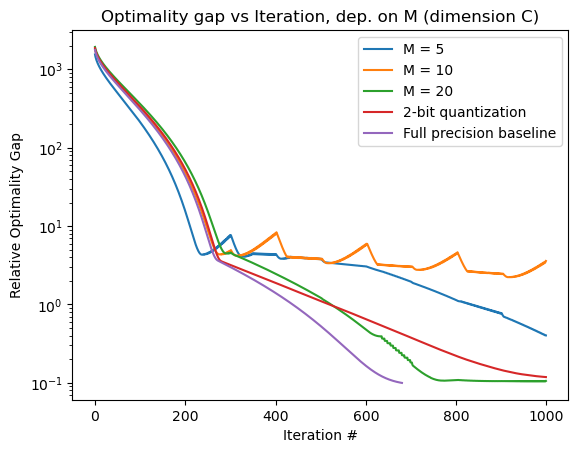

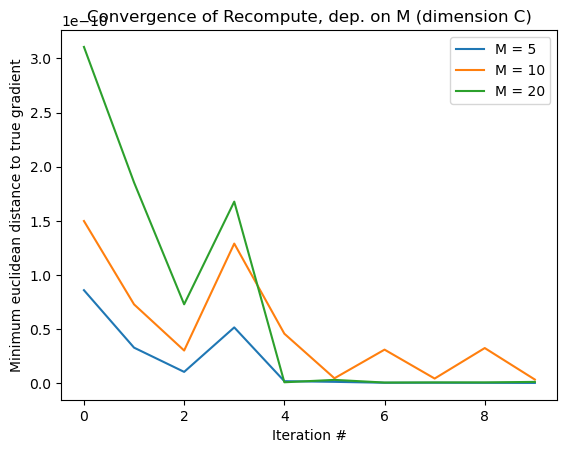

In [125]:
#exp1 = execute(nagents=5, dimC=5, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
#exp2 = execute(nagents=5, dimC=10, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
#exp3 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
print(exp1[4], exp2[4], exp3[4])
plt.yscale("log")
index = 0; #history, compute_history, quantize_history, bit_history, comp_ratio
plt.figure(1)
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on M (dimension C)")
plt.plot(range(len(exp1[index])), exp1[index], label="M = 5")
plt.plot(range(len(exp2[index])), exp2[index], label="M = 10")
plt.plot(range(len(exp3[index])), exp3[index], label="M = 20")
plt.plot(range(len(h2)), h2, label='2-bit quantization')
plt.plot(range(len(h1)), h1, label='Full precision baseline')
plt.legend()

index = 1; 
plt.figure(2)
plt.title("Convergence of Recompute, dep. on M (dimension C)")
plt.xlabel("Iteration #");
plt.ylabel("Minimum euclidean distance to true gradient")
plt.plot(range(len(exp1[index])), exp1[index], label="M = 5")
plt.plot(range(len(exp2[index])), exp2[index], label="M = 10")
plt.plot(range(len(exp3[index])), exp3[index], label="M = 20")
plt.legend()

Starting to compute Lowner-John Ellipsoid...
First solve status =  optimal_inaccurate
Defaulted to border fitting
Second solve status =  optimal


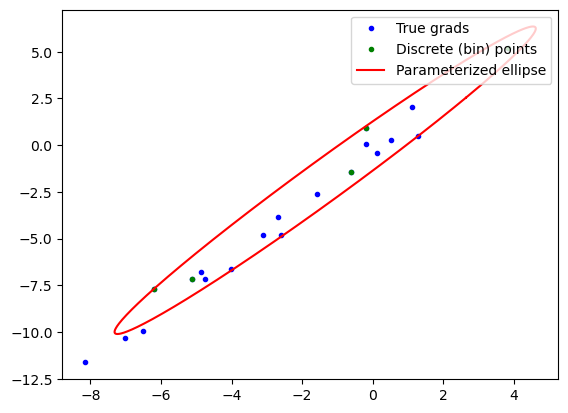

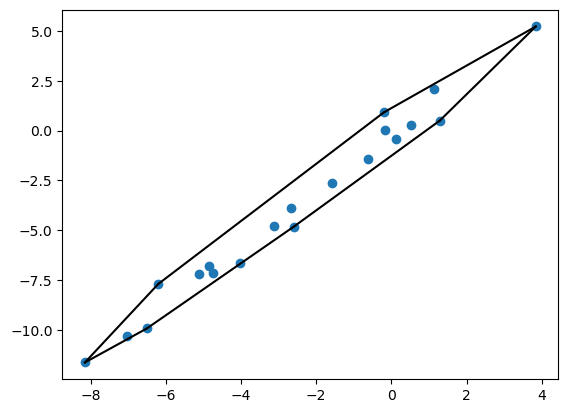

In [45]:
## Plot Ellipse for Presentation Figures ##
m, n = 10, 2
A = np.random.random((m,n))
z = np.random.random((n,))
b = A@z + np.random.random((m))
x = np.zeros((n,));
grads = []

r = 20;
iters = r
dimC = 5;
Q = Quantizer(iters, dimC);
ak = 0.01;
for i in range(r):
    g = A.T@A@x - A.T@b;
    x = x - ak*g + np.random.randn(n)
    grads.append(np.expand_dims(g, 1));
G = np.hstack(grads);

Q.load(G)
Q.compute(False)
Q.plot(G)

plt.figure()
G = G.T
hull = scipy.spatial.ConvexHull(G)
import matplotlib.pyplot as plt
plt.plot(G[:,0], G[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(G[simplex, 0], G[simplex, 1], 'k-')

0.30105 0.2874 0.2913


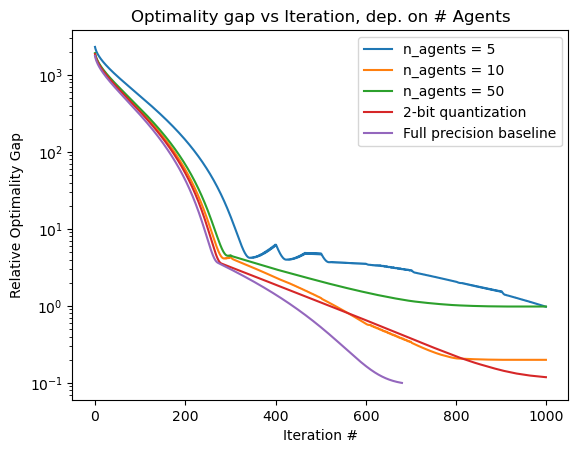

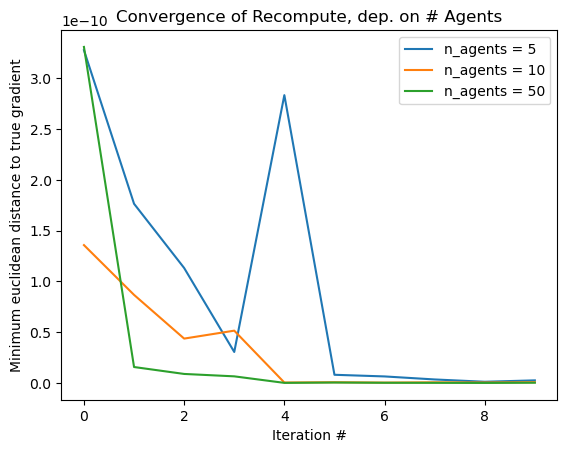

In [124]:
#exp4 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
#exp5 = execute(nagents=10, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
#exp6 = execute(nagents=50, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
print(exp4[4], exp5[4], exp6[4])
plt.yscale("log")
index = 0; #history, compute_history, quantize_history, bit_history, comp_ratio
plt.figure(1)
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on # Agents")
plt.plot(range(len(exp4[index])), exp4[index], label="n_agents = 5")
plt.plot(range(len(exp5[index])), exp5[index], label="n_agents = 10")
plt.plot(range(len(exp6[index])), exp6[index], label="n_agents = 50")
plt.plot(range(len(h2)), h2, label='2-bit quantization')
plt.plot(range(len(h1)), h1, label='Full precision baseline')
plt.legend()

index = 1; 
plt.figure(2)
plt.title("Convergence of Recompute, dep. on # Agents")
plt.xlabel("Iteration #");
plt.ylabel("Minimum euclidean distance to true gradient")
plt.plot(range(len(exp4[index])), exp4[index], label="n_agents = 5")
plt.plot(range(len(exp5[index])), exp5[index], label="n_agents = 10")
plt.plot(range(len(exp6[index])), exp6[index], label="n_agents = 50")
plt.legend()

2.031825 0.511775 0.306448087431694


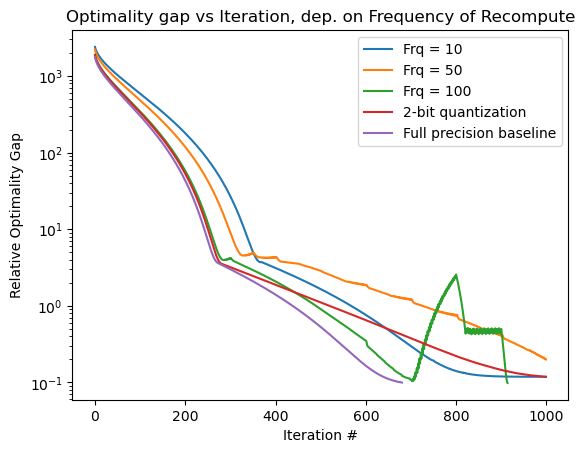

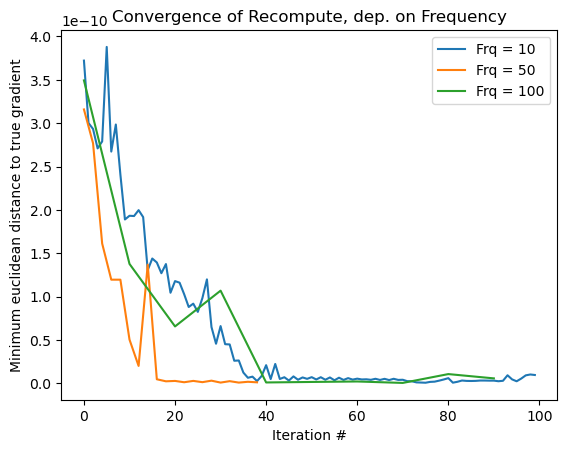

In [123]:
#exp7 = execute(nagents=5, dimC=20, r=10, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
#exp8 = execute(nagents=5, dimC=20, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
#exp9 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False)
print(exp7[4], exp8[4], exp9[4])
plt.yscale("log")
index = 0; #history, compute_history, quantize_history, bit_history, comp_ratio
plt.figure(1)
plt.xlabel("Iteration #");
plt.ylabel("Relative Optimality Gap")
plt.title("Optimality gap vs Iteration, dep. on Frequency of Recompute")
plt.plot(range(len(exp7[index])), exp7[index], label="Frq = 10")
plt.plot(range(len(exp8[index])), exp8[index], label="Frq = 50")
plt.plot(range(len(exp9[index])), exp9[index], label="Frq = 100")
plt.plot(range(len(h2)), h2, label='2-bit quantization')
plt.plot(range(len(h1)), h1, label='Full precision baseline')
plt.legend()

index = 1; 
plt.figure(2)
plt.title("Convergence of Recompute, dep. on Frequency")
plt.xlabel("Iteration #");
plt.ylabel("Minimum euclidean distance to true gradient")
t1 = [2*i for i in range(len(exp8[index]))]
t2 = [10*i for i in range(len(exp9[index]))]
plt.plot(range(len(exp7[index])), exp7[index], label="Frq = 10")
plt.plot(t1, exp8[index], label="Frq = 50")
plt.plot(t2, exp9[index], label="Frq = 100")
plt.legend()

In [44]:
meta = 'exp1 = execute(nagents=5, dimC=5, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp2 = execute(nagents=5, dimC=10, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp3 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp4 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp5 = execute(nagents=10, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp6 = execute(nagents=50, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp7 = execute(nagents=5, dimC=20, r=10, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp8 = execute(nagents=5, dimC=20, r=50, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | \
        exp9 = execute(nagents=5, dimC=20, r=100, m=10000, n=50, iters=1000, lr=0.1, verbose=False) | end'
e = {'1': exp1, '2': exp2, '3': exp3, '4': exp4, '5': exp5, '6': exp6, '7': exp7, '8': exp8, '9': exp9, 'meta':meta}
with open('ellipsoid_06042023.pickle', 'wb') as handle:
    pickle.dump(e, handle, protocol=pickle.HIGHEST_PROTOCOL)